In [2]:
import librosa
import os
from librosa import display
import matplotlib.pyplot as plt

import scipy
import numpy as np


from IPython.display import Audio

# Spectral decomposition of audio data.
we aim to investigate how we can analyse the audio data in this notebook

In [19]:
clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/01-01-01-02-02.wav'
noisy_sample = os.getcwd() + '/sample-noisy-speech-actor-02/01-01-01-01-02_AirConditioner_1.wav'

In [20]:
clean_samples, clean_sampling_rate = librosa.load(clean_sample)
noisy_samples, noisy_sampling_rate = librosa.load(noisy_sample)

In [21]:
len(clean_samples),clean_sampling_rate

(79460, 22050)

In [22]:
len(noisy_samples),noisy_sampling_rate

(80195, 22050)

## Listening to the audio imported

In [56]:
Audio(clean_sample)

## Waveplots of the audios
It plots Amplitute over time. It seems like the homogenous noises (e.g. consistent ones) have fluctuating amplitutes over time.
__This might be useful as their expected amplitute is necessarily 0__
<br>
Amplitutes are not very informative as they only represent the loudness of the audio recording. If we want to select features about emotions of the speaker, we need to somehow extract information from: __tone__, __speed__.
<br>
In order to do this, we examinate the audio data in the __frequency-time domain__.

Text(0.5, 1.0, 'noisy')

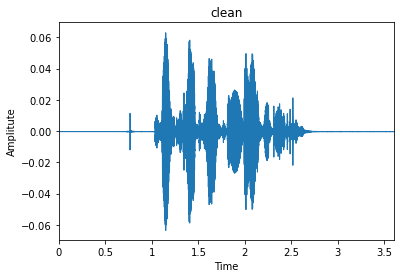

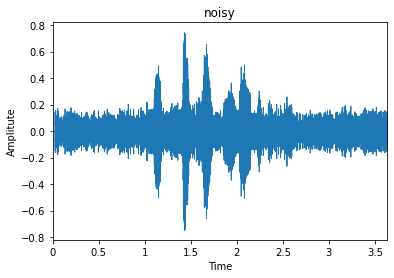

In [25]:
# waveplots (amp vs time)

plt.figure()
display.waveplot(y = clean_samples, sr = clean_sampling_rate)
plt.ylabel('Amplitute')
plt.title('clean')
plt.figure()
display.waveplot(y = noisy_samples, sr = noisy_sampling_rate)
plt.ylabel('Amplitute')
plt.title('noisy')

## Fourier Transform

One way to decompose raw audio data into frequency-time domain is by FT. For each time step, the amplitute as shown above is the __resultant amplitute__ of the magnitutes of various frequency waves. By using FT, we can figure out the differnet frequency waves and their corresponding mangitutes that form the amplitute after addition.

In [26]:
def fft_plot(audio,sampling_rate):
    n = len(audio)
    T = 1/sampling_rate
    yf = scipy.fft.fft(audio)
    xf = np.linspace(0,1/(2*T),n//2)
    
    fig, ax = plt.subplots()
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel('Frequency -->')
    plt.ylabel('Magnitude')
    return plt.show()

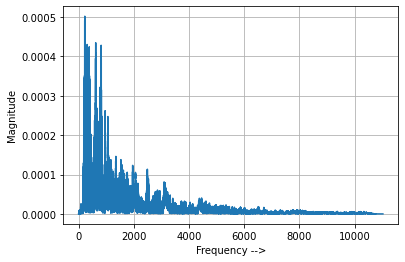

In [27]:
fft_plot(clean_samples, clean_sampling_rate)

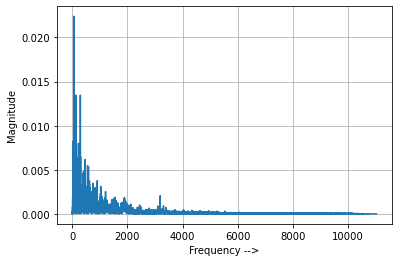

In [28]:
fft_plot(noisy_samples, noisy_sampling_rate)

As we can see above, the frequency of homogenous noises is also, in a sense, homogeous. It seems like that the addition of noises induce only a few frequency waves, and those waves usually have abnormally large amplitude.

## Spectrogram

We decompose further by making the audio file in a spectrogram. This is essentially the same thing as FT above, but now we have a time dimension. At each time point, the frequency waves and their magnitutes are stored.

In [29]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [33]:
spectrogram(clean_samples, sample_rate = clean_sampling_rate)

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [58]:
frequencies, times, spectrogram = scipy.signal.spectrogram(noisy_samples,clean_sampling_rate)

In [54]:
def convert_audio_to_spectogram_log(filename):
    x, sr = librosa.load(filename)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'log')
    plt.colorbar()  

D:\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
D:\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
D:\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


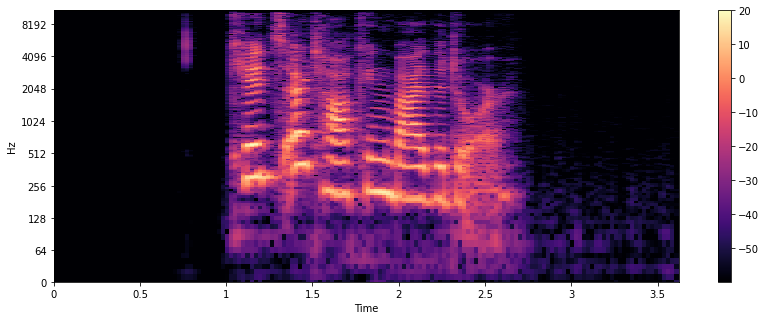

In [55]:
convert_audio_to_spectogram_log(clean_sample)

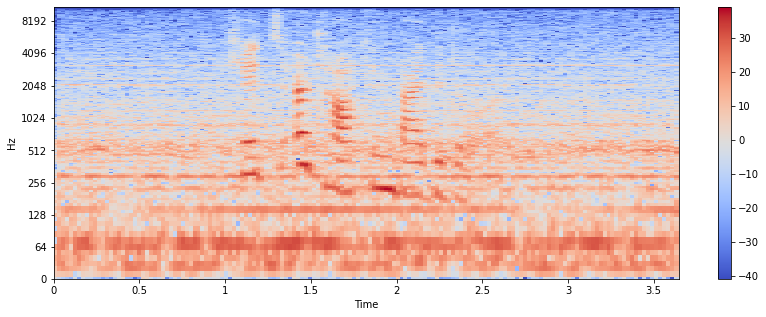

In [57]:
convert_audio_to_spectogram_log(noisy_sample)

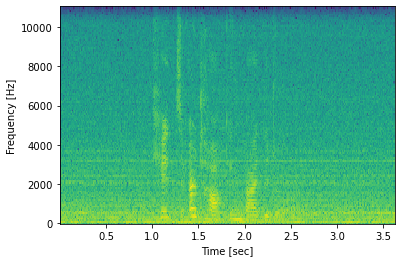

In [59]:
plt.pcolormesh(times, frequencies, np.log(spectrogram),shading='auto')
#plt.imshow(np.log(spectrogram))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()